# Лабораторная работа: Анализ ассоциативных правил

Цель работы: Изучение и практическое применение алгоритмов поиска ассоциативных правил на реальных [данных](https://www.kaggle.com/datasets/gaurav9712/groceries) о покупках в магазине. Ассоциативные правила помогают выявить скрытые закономерности в данных, например, какие товары часто покупаются вместе.

Задачи работы:
- Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ). Данные должны представлять собой информацию о купленных вместе товарах .

- Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др. 

- Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).

- Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.

- Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.

- Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.

- Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.

- Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.

- Ассоциативные правила — это один из ключевых методов анализа данных в машинном обучении, широко применяемый в маркетинге, рекомендательных системах и анализе поведения клиентов. Формат правила: "Если покупатель взял товар A, то с вероятностью X% он также возьмёт товар B".


## Анализ данных

### Описание датасета

В работе используется датасет Groceries (продуктовый магазин), который содержит информацию о покупках клиентов. Каждая строка представляет собой одну транзакцию (покупку), а столбцы содержат названия товаров, которые были куплены в этой транзакции.


### Анализ транзакций

**Распределение длин транзакций:**

Для понимания структуры данных мы анализируем, сколько товаров обычно покупают клиенты. Строится гистограмма, показывающая распределение количества товаров в одной покупке. Это помогает понять:
- Среднее количество товаров в корзине
- Самые частые размеры покупок
- Наличие выбросов (очень больших или очень маленьких покупок)

Как правило, большинство транзакций содержат от 1 до 10 товаров, что соответствует реальному поведению покупателей в продуктовых магазинах.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import networkx as nx

%matplotlib inline

In [3]:
# Выводим "шапку" нашего датасета
all_data = pd.read_csv('groceries.csv', on_bad_lines='skip')

print("Первые строки датасета:")
display(all_data.head())

print("\nРазмер (строки, столбцы):", all_data.shape)


Первые строки датасета:


,citrus fruit,semi-finished bread,margarine,ready soups
0,tropical fruit,yogurt,coffee,NaN
1,whole milk,NaN,NaN,NaN
2,pip fruit,yogurt,cream cheese,meat spreads
3,other vegetables,whole milk,condensed milk,long life bakery product
4,rolls/buns,NaN,NaN,NaN



Размер (строки, столбцы): (6105, 4)


Перед применением алгоритмов данные необходимо преобразовать в формат, понятный для библиотеки mlxtend. Мы используем `TransactionEncoder`, который преобразует список транзакций в бинарную матрицу (one-hot encoding), где:
- Строки соответствуют транзакциям
- Столбцы соответствуют уникальным товарам
- Значение 1 означает, что товар присутствует в транзакции, 0 — отсутствует

In [ ]:
np_data = all_data.to_numpy()

transactions = [
    [item for item in row if isinstance(item, str) and item.strip() != ""]
    for row in np_data
]

transactions = [t for t in transactions if len(t) > 0]

print("Примеры транзакций:")
for t in transactions[:5]:
    print(t)

transaction_lengths = pd.Series([len(t) for t in transactions])

print("\nСтатистика длин транзакций:")
transaction_lengths.describe()


Примеры транзакций:
['tropical fruit', 'yogurt', 'coffee']
['whole milk']
['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads']
['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']
['rolls/buns']

Статистика длин транзакций:


count    6105.000000
mean        2.188043
std         1.090448
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
dtype: float64

# Алгоритм Apriori

Apriori — классический алгоритм поиска частых наборов товаров, основанный на принципе "антимонотонности": если набор товаров не является частым, то любой его подмножество также не будет частым. Алгоритм работает итеративно:
1. Находит все частые наборы из 1 товара
2. На основе них строит кандидатов из 2 товаров
3. Проверяет их частоту и продолжает для наборов из 3, 4 и более товаров

**Параметры алгоритма:**
- **min_support** (минимальная поддержка) — минимальная доля транзакций, в которых должен встречаться набор товаров.
- **min_confidence** (минимальная достоверность) — минимальная вероятность того, что при наличии товаров-предпосылок (antecedents) будет куплен товар-следствие (consequent).

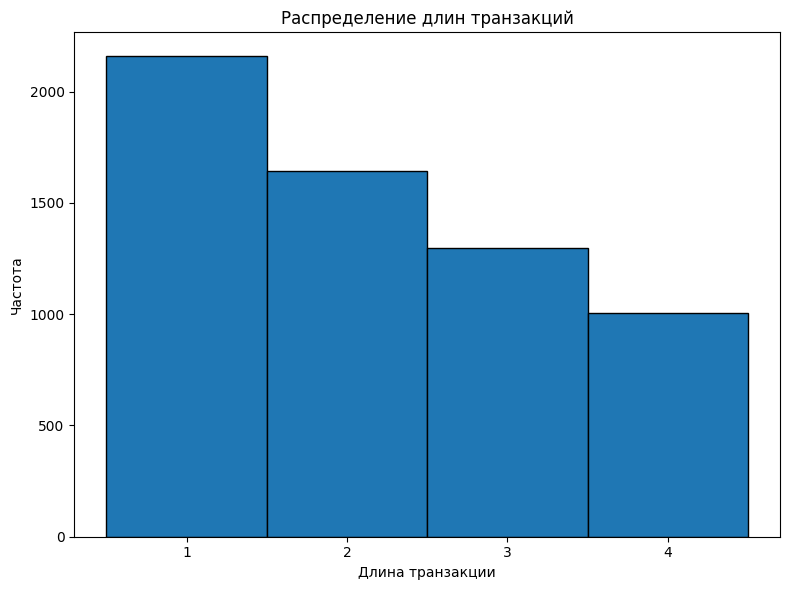

In [6]:
# Строим гистограмму длины транзакций
plt.figure(figsize=(8,6))
plt.hist(
    transaction_lengths,
    bins=range(1, transaction_lengths.max()+2),
    edgecolor="black",
    align="left"
)
plt.xlabel("Длина транзакции")
plt.ylabel("Частота")
plt.title("Распределение длин транзакций")
plt.xticks(range(1, transaction_lengths.max()+1))
plt.tight_layout()
plt.show()


In [ ]:
unique_items = set()
for t in transactions:
    for item in t:
        unique_items.add(item)

print("Количество уникальных товаров:", len(unique_items))
print("Пример на основе 15 строк:", list(unique_items)[:15])

Количество уникальных товаров: 165
Пример на основе 15 строк: ['nut snack', 'seasonal products', 'organic sausage', 'pot plants', 'processed cheese', 'rum', 'spices', 'napkins', 'sugar', 'red/blush wine', 'rice', 'instant coffee', 'chocolate marshmallow', 'fruit/vegetable juice', 'dog food']


In [ ]:

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

binary_df = pd.DataFrame(te_ary, columns=te.columns_)

print("Размер бинарной таблицы:", binary_df.shape)
display(binary_df.head())


Размер бинарной таблицы: (6105, 165)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:

base_min_support = 0.002
base_min_confidence = 0.13

In [10]:
freq_apr = apriori(binary_df, min_support=base_min_support, use_colnames=True)
freq_apr["len"] = freq_apr["itemsets"].apply(len)

print("Частых наборов Apriori:", len(freq_apr))
print(freq_apr.head())

rules_apr = association_rules(freq_apr, metric="confidence", min_threshold=base_min_confidence)

rules_apr["antecedents_str"] = rules_apr["antecedents"].apply(lambda x: ", ".join(list(x)))
rules_apr["consequents_str"] = rules_apr["consequents"].apply(lambda x: ", ".join(list(x)))
rules_apr["rule_str"] = rules_apr["antecedents_str"] + " -> " + rules_apr["consequents_str"]

print("Правил Apriori:", len(rules_apr))
rules_apr.head(10)

Частых наборов Apriori: 270
    support                 itemsets  len
0  0.003112  (Instant food products)    1
1  0.015561               (UHT-milk)    1
2  0.004914          (baking powder)    1
3  0.023915                   (beef)    1
4  0.012285                (berries)    1
Правил Apriori: 77


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,(UHT-milk),(soda),0.015561,0.126618,0.002129,0.136842,1.080752,1.0,0.000159,1.011846,0.075899,0.015205,0.011707,0.076830,UHT-milk,soda,UHT-milk -> soda
1,(beef),(other vegetables),0.023915,0.086978,0.004750,0.198630,2.283685,1.0,0.002670,1.139327,0.575883,0.044753,0.122289,0.126622,beef,other vegetables,beef -> other vegetables
2,(beef),(root vegetables),0.023915,0.037183,0.003604,0.150685,4.052562,1.0,0.002714,1.133640,0.771698,0.062678,0.117886,0.123801,beef,root vegetables,beef -> root vegetables
3,(beef),(whole milk),0.023915,0.140704,0.003931,0.164384,1.168291,1.0,0.000566,1.028337,0.147578,0.024465,0.027557,0.096162,beef,whole milk,beef -> whole milk
4,(berries),(whipped/sour cream),0.012285,0.026536,0.002621,0.213333,8.039506,1.0,0.002295,1.237455,0.886505,0.072398,0.191890,0.156049,berries,whipped/sour cream,berries -> whipped/sour cream
5,(berries),(yogurt),0.012285,0.062899,0.002785,0.226667,3.603646,1.0,0.002012,1.211768,0.731490,0.038462,0.174760,0.135469,berries,yogurt,berries -> yogurt
6,(beverages),(rolls/buns),0.018346,0.126126,0.002457,0.133929,1.061862,1.0,0.000143,1.009009,0.059347,0.017301,0.008929,0.076705,beverages,rolls/buns,beverages -> rolls/buns
7,(beverages),(whole milk),0.018346,0.140704,0.002457,0.133929,0.951844,1.0,-0.000124,0.992176,-0.049012,0.015690,-0.007885,0.075695,beverages,whole milk,beverages -> whole milk
8,(liquor),(bottled beer),0.010483,0.066503,0.005897,0.562500,8.458282,1.0,0.005200,2.133708,0.891114,0.082949,0.531332,0.325585,liquor,bottled beer,liquor -> bottled beer
9,(red/blush wine),(bottled beer),0.013432,0.066503,0.002948,0.219512,3.300793,1.0,0.002055,1.196043,0.706532,0.038298,0.163910,0.131924,red/blush wine,bottled beer,red/blush wine -> bottled beer


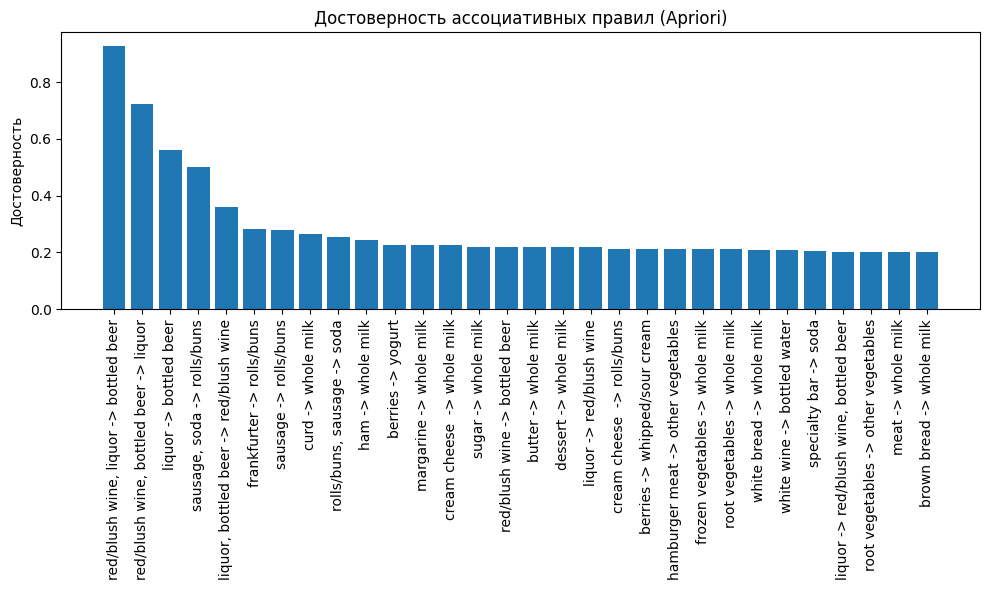

In [ ]:

if len(rules_apr) > 0:
    top = rules_apr.sort_values("confidence", ascending=False).head(30)

    plt.figure(figsize=(10,6))
    plt.bar(range(len(top)), top["confidence"])
    plt.xticks(range(len(top)), top["rule_str"], rotation=90)
    plt.title("Достоверность ассоциативных правил (Apriori)")
    plt.ylabel("Достоверность")
    plt.tight_layout()
    plt.show()
else:
    print("Нет правил Apriori")


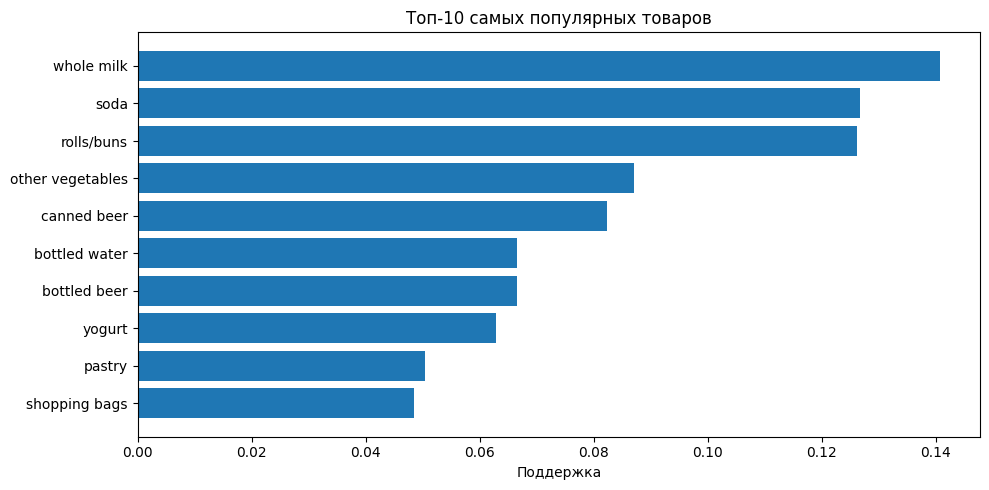

In [12]:

one_itemsets = freq_apr[freq_apr["len"] == 1].copy()

if len(one_itemsets) > 0:
    one_itemsets["item"] = one_itemsets["itemsets"].apply(lambda x: list(x)[0])
    top10 = one_itemsets.sort_values("support", ascending=False).head(10)

    plt.figure(figsize=(10,5))
    plt.barh(top10["item"], top10["support"])
    plt.title("Топ-10 самых популярных товаров")
    plt.xlabel("Поддержка")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# Алгоритм FP-Growth

FP-Growth (Frequent Pattern Growth) — более эффективный алгоритм, использующий специальную структуру данных FP-tree (дерево частых паттернов). В отличие от Apriori, который требует многократного сканирования базы данных, FP-Growth строит компактное дерево и работает с ним, что делает его значительно быстрее на больших датасетах.

**Преимущества FP-Growth:**
- Меньше проходов по данным
- Более эффективное использование памяти
- Быстрее работает на больших объёмах данных

**Результаты работы FP-Growth:**

Алгоритм даёт те же результаты, что и Apriori (частые наборы и правила), но работает быстрее. Мы сравниваем количество найденных правил и их характеристики.


In [13]:

freq_fpg = fpgrowth(binary_df, min_support=base_min_support, use_colnames=True)
freq_fpg["len"] = freq_fpg["itemsets"].apply(len)

print("Частых наборов FPGrowth:", len(freq_fpg))
display(freq_fpg.head())

rules_fpg = association_rules(freq_fpg, metric="confidence", min_threshold=base_min_confidence)

rules_fpg["antecedents_str"] = rules_fpg["antecedents"].apply(lambda x: ", ".join(list(x)))
rules_fpg["consequents_str"] = rules_fpg["consequents"].apply(lambda x: ", ".join(list(x)))
rules_fpg["rule_str"] = rules_fpg["antecedents_str"] + " -> " + rules_fpg["consequents_str"]

print("Правил FPG:", len(rules_fpg))
display(rules_fpg.head(10))


Частых наборов FPGrowth: 270


,support,itemsets,len
0,0.062899,(yogurt),1
1,0.039803,(tropical fruit),1
2,0.033743,(coffee),1
3,0.140704,(whole milk),1
4,0.030958,(pip fruit),1


Правил FPG: 77


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,(yogurt),(whole milk),0.062899,0.140704,0.008354,0.132812,0.943912,1.0,-0.000496,0.990899,-0.059628,0.042785,-0.009184,0.096092,yogurt,whole milk,yogurt -> whole milk
1,(tropical fruit),(whole milk),0.039803,0.140704,0.006716,0.168724,1.199141,1.0,0.001115,1.033707,0.172954,0.038643,0.032608,0.108227,tropical fruit,whole milk,tropical fruit -> whole milk
2,(coffee),(whole milk),0.033743,0.140704,0.004586,0.135922,0.966014,1.0,-0.000161,0.994466,-0.035131,0.027001,-0.005565,0.084259,coffee,whole milk,coffee -> whole milk
3,(pip fruit),(whole milk),0.030958,0.140704,0.004750,0.153439,1.090508,1.0,0.000394,1.015043,0.085647,0.028459,0.014820,0.093600,pip fruit,whole milk,pip fruit -> whole milk
4,(cream cheese ),(whole milk),0.014578,0.140704,0.003276,0.224719,1.597101,1.0,0.001225,1.108367,0.379397,0.021552,0.097772,0.124001,cream cheese,whole milk,cream cheese -> whole milk
5,(cream cheese ),(rolls/buns),0.014578,0.126126,0.003112,0.213483,1.692616,1.0,0.001274,1.111068,0.415252,0.022619,0.099965,0.119079,cream cheese,rolls/buns,cream cheese -> rolls/buns
6,(other vegetables),(whole milk),0.086978,0.140704,0.014578,0.167608,1.191209,1.0,0.002340,1.032321,0.175808,0.068409,0.031309,0.135609,other vegetables,whole milk,other vegetables -> whole milk
7,(rolls/buns),(soda),0.126126,0.126618,0.017854,0.141558,1.118000,1.0,0.001884,1.017405,0.120779,0.076011,0.017107,0.141284,rolls/buns,soda,rolls/buns -> soda
8,(soda),(rolls/buns),0.126618,0.126126,0.017854,0.141009,1.118000,1.0,0.001884,1.017326,0.120847,0.076011,0.017031,0.141284,soda,rolls/buns,soda -> rolls/buns
9,(beef),(whole milk),0.023915,0.140704,0.003931,0.164384,1.168291,1.0,0.000566,1.028337,0.147578,0.024465,0.027557,0.096162,beef,whole milk,beef -> whole milk


In [16]:
min_support_by_len = (
    freq_fpg.groupby("len")["support"].min().reset_index().sort_values("len")
)

print("Минимальные поддержки по длинам наборов:")
display(min_support_by_len)

for _, row in min_support_by_len.iterrows():
    print(f"Длина {int(row['len'])}: минимальная поддержка = {row['support']:.4f}")


Минимальные поддержки по длинам наборов:


,len,support
0,1,0.002129
1,2,0.002129
2,3,0.002129


Длина 1: минимальная поддержка = 0.0021
Длина 2: минимальная поддержка = 0.0021
Длина 3: минимальная поддержка = 0.0021


c:\Users\alehi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


# Анализ влияния параметров

**Экспериментальное исследование:**

Для понимания влияния параметров на результаты мы проводим серию экспериментов, варьируя:
- **min_support**: 0.002, 0.003, 0.004, 0.005
- **min_confidence**: 0.05, 0.10, 0.15, 0.20

Для каждой комбинации параметров мы измеряем:
- Количество найденных правил
- Среднюю поддержку правил
- Среднюю достоверность правил
- Средний lift (лифт) — метрику, показывающую, насколько правило лучше случайного

Результаты визуализируются с помощью тепловой карты (heatmap), где:
- По оси X откладывается min_confidence
- По оси Y откладывается min_support
- Цвет ячейки и число в ней показывают количество найденных правил

,min_support,min_confidence,n_rules,avg_support,avg_confidence,avg_lift
0,0.002,0.05,195,0.004713,0.130749,2.680741
1,0.002,0.10,103,0.005011,0.185057,3.864891
2,0.002,0.15,56,0.004472,0.233733,6.113674
3,0.002,0.20,30,0.004139,0.288994,8.628237
4,0.003,0.05,125,0.005982,0.127788,1.542424
5,0.003,0.10,70,0.006220,0.172712,1.641285
6,0.003,0.15,36,0.005615,0.216377,2.047808
7,0.003,0.20,18,0.005296,0.260952,2.321997
8,0.004,0.05,80,0.007383,0.126104,1.407197
9,0.004,0.10,45,0.007739,0.169382,1.478652


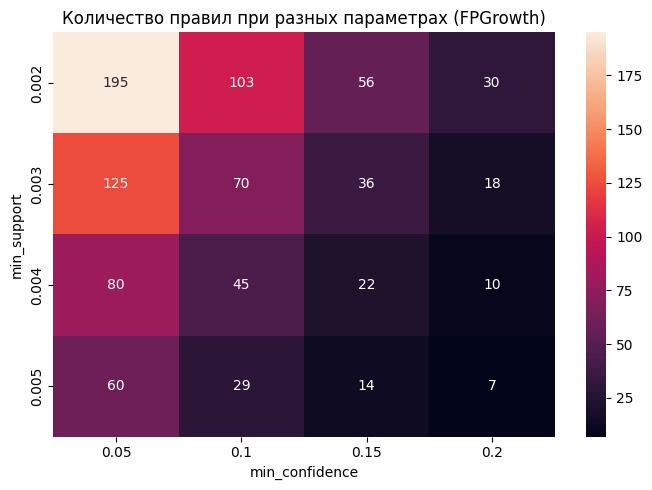

In [18]:
support_values = [0.002, 0.003, 0.004, 0.005]
confidence_values = [0.05, 0.10, 0.15, 0.20]

exp_results = []

for ms in support_values:
    freq_tmp = fpgrowth(binary_df, min_support=ms, use_colnames=True)

    if len(freq_tmp) == 0:
        exp_results.append({
            "min_support": ms,
            "min_confidence": None,
            "n_rules": 0,
            "avg_support": np.nan,
            "avg_confidence": np.nan,
            "avg_lift": np.nan
        })
        continue

    for mc in confidence_values:
        rules_tmp = association_rules(freq_tmp, metric="confidence", min_threshold=mc)
        if len(rules_tmp) == 0:
            exp_results.append({
                "min_support": ms,
                "min_confidence": mc,
                "n_rules": 0,
                "avg_support": np.nan,
                "avg_confidence": np.nan,
                "avg_lift": np.nan
            })
        else:
            exp_results.append({
                "min_support": ms,
                "min_confidence": mc,
                "n_rules": len(rules_tmp),
                "avg_support": float(rules_tmp["support"].mean()),
                "avg_confidence": float(rules_tmp["confidence"].mean()),
                "avg_lift": float(rules_tmp["lift"].mean())
            })

exp_df = pd.DataFrame(exp_results)
display(exp_df)

pivot = exp_df.pivot(
    index="min_support",
    columns="min_confidence",
    values="n_rules"
)

plt.figure(figsize=(7, 5))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("Количество правил при разных параметрах (FPGrowth)")
plt.ylabel("min_support")
plt.xlabel("min_confidence")
plt.tight_layout()
plt.show()


c:\Users\alehi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


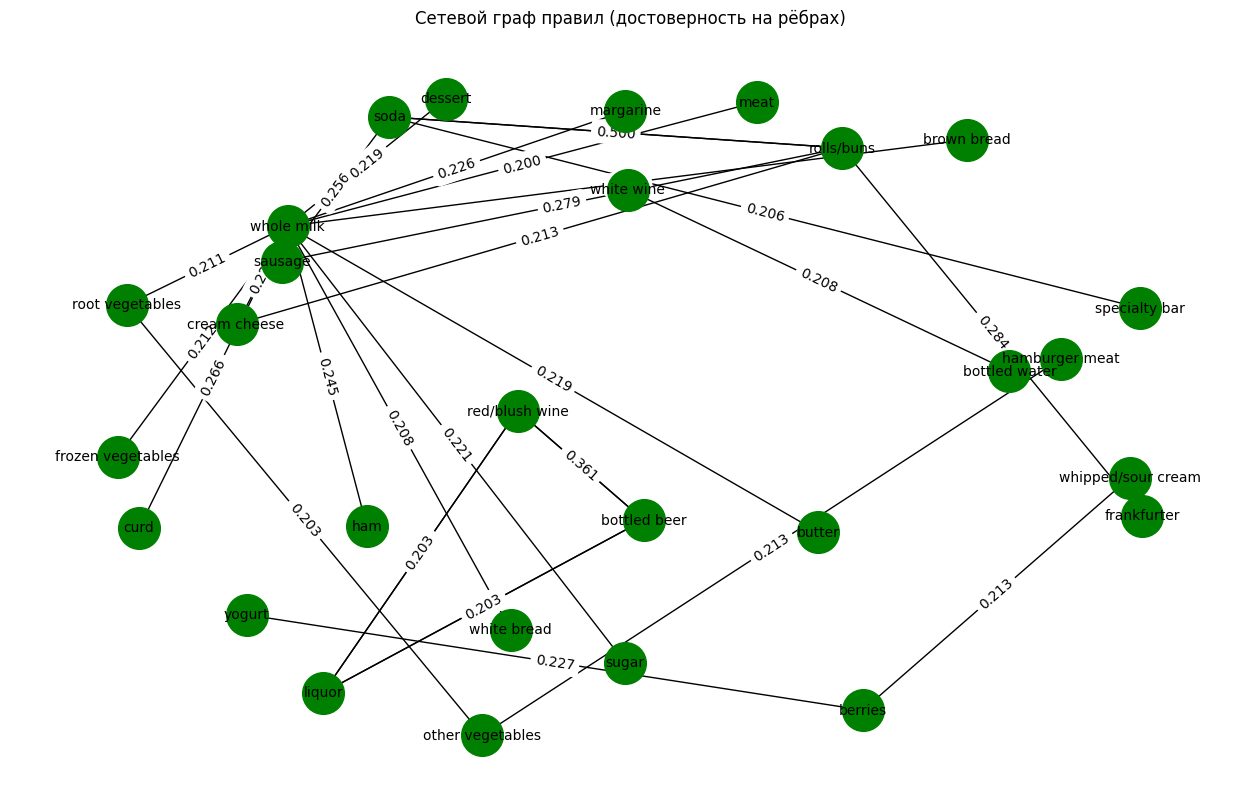

In [ ]:
if len(rules_fpg) > 0:
    rules_for_graph = rules_fpg.sort_values("confidence", ascending=False).head(30)

    G = nx.DiGraph()

    for _, row in rules_for_graph.iterrows():
        ants = list(row["antecedents"])
        cons = list(row["consequents"])
        conf = row["confidence"]

        for a in ants:
            for c in cons:
                if not G.has_node(a):
                    G.add_node(a)
                if not G.has_node(c):
                    G.add_node(c)
                G.add_edge(a, c, weight=conf)

    plt.figure(figsize=(16,10))
    pos = nx.spring_layout(G, k=0.8, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=900, node_color="green")
    nx.draw_networkx_labels(G, pos, font_size=10)
    nx.draw_networkx_edges(G, pos, arrows=True)

    edge_labels = {(u,v): f"{d['weight']:.3f}" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Сетевой граф правил")
    plt.axis("off")
    plt.show()

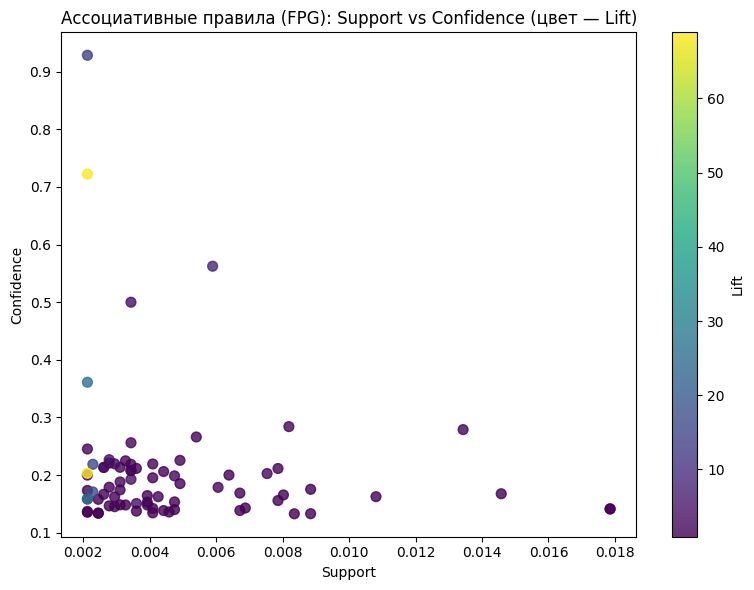

In [21]:

if len(rules_fpg) > 0:
    plt.figure(figsize=(8,6))
    sc = plt.scatter(
        rules_fpg["support"],
        rules_fpg["confidence"],
        c=rules_fpg["lift"],
        s=50,
        alpha=0.8
    )
    plt.colorbar(sc, label="Lift")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Ассоциативные правила (FPG): Support vs Confidence (цвет — Lift)")
    plt.tight_layout()
    plt.show()
else:
    print("Правил нет — scatter построить невозможно")


## Заключение

В ходе лабораторной работы были успешно применены два алгоритма поиска ассоциативных правил — Apriori и FPG — на реальных данных о покупках в продуктовом магазине.

**Основные результаты:**

1. **Анализ данных показал:**
   - Структуру транзакций и распределение количества товаров в покупках
   - Разнообразие ассортимента магазина
   - Наличие закономерностей в покупках клиентов

2. **Сравнение алгоритмов:**
   - Оба алгоритма (Apriori и FP-Growth) дают одинаковые результаты по найденным правилам
   - FP-Growth работает быстрее, особенно на больших датасетах
   - Для небольших датасетов разница в скорости может быть не критична

3. **Влияние параметров:**
   - Минимальная поддержка (min_support) напрямую влияет на количество найденных частых наборов — чем выше поддержка, тем меньше наборов
   - Минимальная достоверность (min_confidence) влияет на количество правил — более высокие значения дают более надёжные, но менее многочисленные правила
   - Необходимо находить баланс между количеством и качеством правил в зависимости от задачи

4. **Практическая ценность:**
   - Найденные ассоциативные правила могут быть использованы для:
     - Размещения товаров в магазине (товары, покупаемые вместе, размещать рядом)
     - Создания рекомендательных систем
     - Разработки маркетинговых акций (скидки на связанные товары)
     - Управления запасами

5. **Визуализация:**
   - Сетевой граф эффективно показывает структуру связей между товарами
   - Scatter plot помогает оценить качество правил по нескольким метрикам одновременно
   - Комбинация различных визуализаций даёт полную картину найденных закономерностей

**Выводы:**

Алгоритмы поиска ассоциативных правил являются мощным инструментом для анализа данных о транзакциях. Они позволяют выявлять скрытые закономерности, которые не очевидны при простом просмотре данных. Правильный выбор параметров и методов визуализации критически важен для получения практических результатов, которые можно использовать в реальных бизнес-задачах.

Работа продемонстрировала, что анализ ассоциативных правил — это не просто техническое упражнение, а реальный инструмент для принятия решений в розничной торговле и других областях, где важны закономерности в поведении клиентов.
